**Write the names of all group members (max. 5 members)**:
- Zhexin Wu
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import lightgbm as lgbm
import torch
import torch.nn as nn
import lightning.pytorch as pl
import optuna
import os
import glob
import pickle

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_poisson_deviance,
)
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from torch.optim import AdamW, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import MetricCollection
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from optuna.pruners import MedianPruner
from optuna.integration import PyTorchLightningPruningCallback, OptunaSearchCV
from tqdm.notebook import tqdm

In [2]:
torch.__version__, torch.cuda.is_available()

('2.4.1+cu118', True)

In [3]:
sns.set_theme()

In [4]:
DATA_FILENAME = "data/freMTPL2freq.csv"
SEED = 100
TEST_SIZE = .1

NN_TRAIN_CONFIG = {
    "batch_size": 10_000,
    "num_epochs": 100,
    "lr": 1e-2,
    "seed": SEED,
    "val_size": 0.1,
    "opt_cls": AdamW,
    "scheduler_params": {
        "model_cls": ReduceLROnPlateau,
        "params": {
            "mode": "min",
            "factor": 0.5,
            "patience": 10,
            "min_lr": 1e-5,
            "threshold": 1e-3,
        },
    },
}

TUNING_PARAMS = {
    "n_trials": 15,
}

In [5]:
def model_evaluation(model, X_train, y_train, weights_train, X_test, y_test, weights_test, y_train_pred=None, y_test_pred=None):
    metrics = [mean_absolute_error, mean_squared_error, mean_poisson_deviance]
    
    def eval_step(X, y, weights, y_pred=None):
        metric_dict = {}
        if y_pred is None:
            y_pred = model.predict(X)
        for metric in metrics:
            sample_weights = None
            if metric == mean_poisson_deviance:
                sample_weights = weights
            metric_dict[metric.__name__] = metric(y, y_pred, sample_weight=sample_weights)
        
        return metric_dict
    
    metric_dict = {}
    metric_dict["train"] = eval_step(X_train, y_train, weights_train, y_train_pred)
    metric_dict["test"] = eval_step(X_test, y_test, weights_test, y_test_pred)
    metric_df = pd.DataFrame(metric_dict)
    
    return metric_df

# Exercise 1 (Poisson GLM)

### Question 1.a

In [6]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data_all_df_in = pd.read_csv(DATA_FILENAME, header=[0], delimiter=";")
data_all_df_in["Exposure"] = data_all_df_in["Exposure"].apply(lambda x_str: float(x_str.replace(",", ".")))
data_all_df_in

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb
0,4,9,23,100,B6,Regular,7887,R31,0.760000,0
1,4,6,26,100,B6,Regular,2308,R31,0.740000,0
2,4,6,26,100,B6,Regular,2308,R31,0.110000,0
3,7,4,44,50,B6,Regular,37,R94,0.830000,0
4,5,2,29,90,B6,Regular,335,R91,0.690000,0
...,...,...,...,...,...,...,...,...,...,...
678002,6,10,27,118,B1,Diesel,1978,R31,0.120000,0
678003,4,9,34,76,B1,Regular,6681,R11,0.060000,0
678004,4,15,37,50,B1,Regular,1767,R31,0.060000,0
678005,4,15,69,50,B1,Regular,1541,R91,0.060000,0


In [7]:
data_all_df_in.info()  # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


In [8]:
# Pre-process features

<span style="color: blue;"><b>Note:</b></span>
Standardization and one-hot encoding should be performed at runtime according to statistics of the training set. To facilitate cross validation, we will integrate these two transforms into a pipepline with a sklearn-like model.

In [9]:
data_all_df = data_all_df_in.copy()
for feat_name in ["VehPower", "DrivAge", "BonusMalus", "Density"]:
    data_all_df[feat_name] = np.log(data_all_df[feat_name])

def func(x: float):
    assert x >= 0
    if x < 6:
        return 0
    elif x >= 13:
        return 2
    return 1

data_all_df["VehAge"] = data_all_df["VehAge"].apply(func).astype("category")
data_all_df["ClaimFreq"] = data_all_df["ClaimNb"] / data_all_df["Exposure"]
data_all_df

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb,ClaimFreq
0,1.386294,1,3.135494,4.605170,B6,Regular,8.972971,R31,0.760000,0,0.0
1,1.386294,1,3.258097,4.605170,B6,Regular,7.744137,R31,0.740000,0,0.0
2,1.386294,1,3.258097,4.605170,B6,Regular,7.744137,R31,0.110000,0,0.0
3,1.945910,0,3.784190,3.912023,B6,Regular,3.610918,R94,0.830000,0,0.0
4,1.609438,0,3.367296,4.499810,B6,Regular,5.814131,R91,0.690000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
678002,1.791759,1,3.295837,4.770685,B1,Diesel,7.589842,R31,0.120000,0,0.0
678003,1.386294,1,3.526361,4.330733,B1,Regular,8.807023,R11,0.060000,0,0.0
678004,1.386294,2,3.610918,3.912023,B1,Regular,7.477038,R31,0.060000,0,0.0
678005,1.386294,2,4.234107,3.912023,B1,Regular,7.340187,R91,0.060000,0,0.0


In [10]:
def create_preprocessing_steps(if_norm=False, if_one_hot=False):
    tfms = []
    if if_norm:
        tfms.append((
            "normalizer",
            StandardScaler(),
            make_column_selector(dtype_include="number"),
        ))
        
    if if_one_hot:
        tfms.append((
            "one_hot_enc",
            OneHotEncoder(handle_unknown="ignore"),
            make_column_selector(dtype_exclude="number"),
        ))
    col_tfm = ColumnTransformer(tfms, remainder="passthrough")
    
    return col_tfm

col_tfm_check = create_preprocessing_steps(if_one_hot=True)
col_tfm_check

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot_enc',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000011FD47D4C10>)])

#### Data exploration to better understand the features

In [11]:
def create_hist(df: pd.DataFrame, x_name: str, y_name: str, axis, num_samples=20_000, random_state=SEED):
    df = df.sample(n=num_samples, random_state=random_state)
    axis = sns.regplot(data=df, x=x_name, y=y_name, ax=axis, line_kws={"color": "red"})
    model = sm.OLS(df[y_name], sm.add_constant(df[x_name]))
    res = model.fit()
    r_sq = res.rsquared
    axis.set_title("$R^2 = $" + f"{r_sq:.3e}")
    
    
def create_boxplot(df: pd.DataFrame, x_name: str, y_name: str, axis, num_samples=20_000, random_state=SEED):
    df = df.sample(n=num_samples, random_state=random_state)
    axis = sns.boxplot(data=df, x=x_name, y=y_name, ax=axis)

Continous features:


  0%|          | 0/4 [00:00<?, ?it/s]

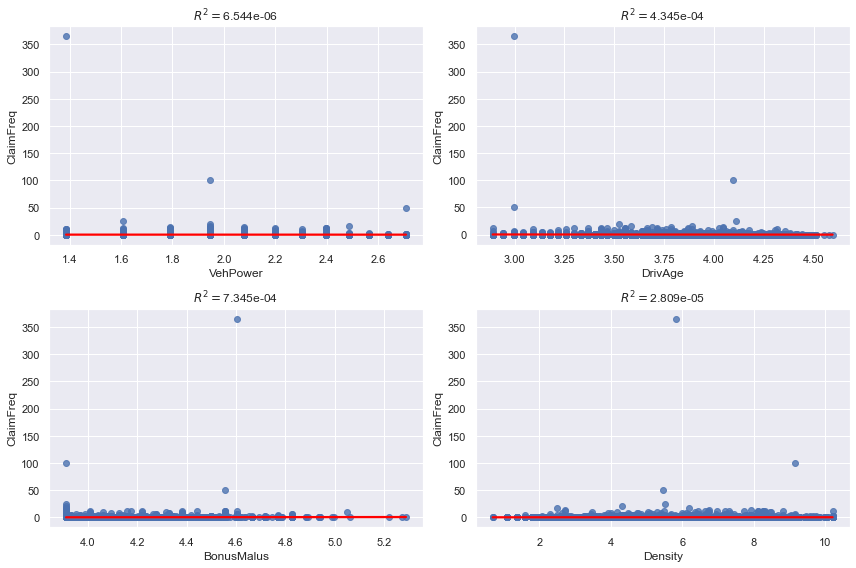

In [12]:
print("Continous features:")
cont_feats = data_all_df.iloc[:, :-3].select_dtypes(include="number").columns
fig, axes = plt.subplots(2, len(cont_feats) // 2, figsize=(12, 8))
y_name = "ClaimFreq"
for x_name, axis in tqdm(zip(cont_feats, axes.flatten()), total=len(cont_feats)):
    create_hist(data_all_df, x_name, y_name, axis)
fig.tight_layout()

Categorical features:


  0%|          | 0/4 [00:00<?, ?it/s]

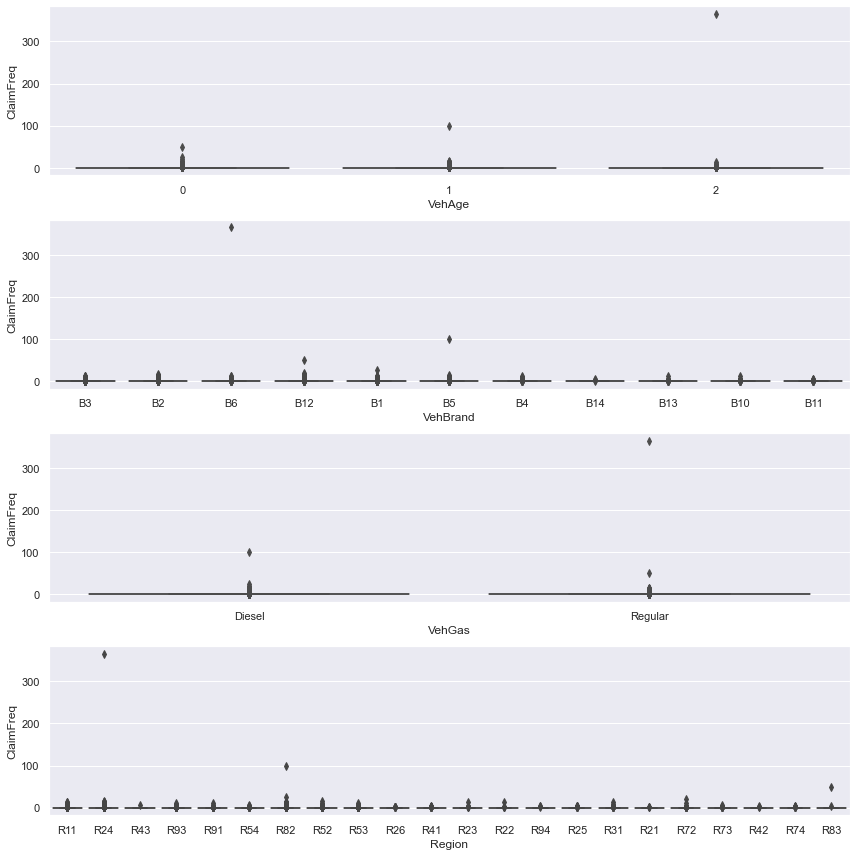

In [13]:
print("Categorical features:")
cate_feats = data_all_df.iloc[:, :-3].select_dtypes(exclude="number").columns
fig, axes = plt.subplots(len(cate_feats), 1, figsize=(12, 12))
y_name = "ClaimFreq"
for x_name, axis in tqdm(zip(cate_feats, axes.flatten()), total=len(cate_feats)):
    create_boxplot(data_all_df, x_name, y_name, axis)
fig.tight_layout()

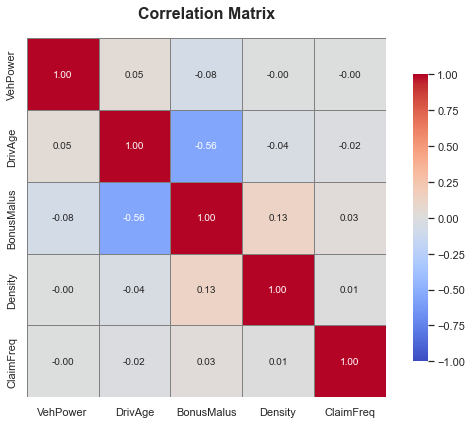

In [14]:
corr = data_all_df[list(cont_feats) + ["ClaimFreq"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1, 
    square=True, 
    cbar_kws={"shrink": 0.8}, 
    linewidths=0.5, 
    linecolor="gray",
)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

<span style="color: blue;"><b>Comments:</b></span>
- Low correlation between independent variables
- There is substantial amount of values close to zero in the dependent variable
- OLS can be highly biased
- Thus GLM like Poisson GLM and its deep-learning extension can be more suitable

### Question 1.b

In [15]:
# Train-test split
data_train_df, data_test_df = train_test_split(data_all_df, test_size=TEST_SIZE, random_state=SEED)
X_train, y_train = data_train_df.iloc[:, :-3], data_train_df.iloc[:, -3:]
X_test, y_test = data_test_df.iloc[:, :-3], data_test_df.iloc[:, -3:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((610206, 8), (610206, 3), (67801, 8), (67801, 3))

In [16]:
%%capture
# Train Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
model_pipeline = Pipeline(
    [
        ("preprocessor", create_preprocessing_steps(if_norm=True, if_one_hot=True)),
        ("model", PoissonRegressor(alpha=0.))
    ]
)
sample_weights = y_train["Exposure"]
model_pipeline.fit(X_train, y_train["ClaimFreq"], model__sample_weight=sample_weights)

In [17]:
num_feats = model_pipeline.named_steps["preprocessor"].get_feature_names_out().shape
print(f"Number of features: {num_feats[0]}")

Number of features: 42


In [18]:
# Print MAE, MSE and loss on train and test data sets
metric_df = model_evaluation(
    model_pipeline, 
    X_train, y_train["ClaimFreq"], y_train["Exposure"],
    X_test, y_test["ClaimFreq"], y_test["Exposure"],
)
metric_df

,train,test
mean_absolute_error,0.188761,0.189633
mean_squared_error,3.720199,6.617915
mean_poisson_deviance,0.456392,0.461924


<span style="color: blue;"><b>Notes:</b></span>
- Mean Poisson deviance is weighted by "Exposure"

# Exercise 2 (Poisson FNN)

### Question 2.a

In [19]:
class InsuranceClaimDataModule(pl.LightningDataModule):
    def __init__(self, params: dict, *args):
        """
        params: batch_size, val_size, seed, num_workers
        """
        super().__init__()
        self.params = params
        self.seed = self.params.get("seed", SEED)
        self.num_workers = self.params.get("num_workers", 0)
        self.X_train, self.y_train, self.X_test, self.y_test = args
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, 
            self.y_train, 
            test_size=self.params["val_size"],
            random_state=self.seed,
        )
        self.col_tfm = create_preprocessing_steps(if_norm=True, if_one_hot=True)

    def setup(self, stage: str = "fit"):
        if stage == "fit":
            X_train = self.col_tfm.fit_transform(self.X_train)
            self.train_ds = TensorDataset(torch.tensor(X_train.toarray()).float(), torch.tensor(self.y_train.values).float())
            X_val = self.col_tfm.transform(self.X_val)
            self.val_ds = TensorDataset(torch.tensor(X_val.toarray()).float(), torch.tensor(self.y_val.values).float())
        
        if stage in ["test", "predict"]:
            X_test = self.col_tfm.transform(self.X_test)
            self.test_ds = TensorDataset(torch.tensor(X_test.toarray()).float(), torch.tensor(self.y_test.values).float())
    
    def train_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.train_ds, batch_size=self.params["batch_size"], shuffle=True, num_workers=self.num_workers)
        return data_loader
    
    def val_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.val_ds, batch_size=self.params["batch_size"], num_workers=self.num_workers)
        return data_loader
    
    def test_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"], num_workers=self.num_workers)
        return data_loader
    
    def predict_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"], num_workers=self.num_workers)
        return data_loader


data_module_check = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
data_module_check.setup("fit")
for X_iter, y_iter in data_module_check.train_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

for X_iter, y_iter in data_module_check.val_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

data_module_check.setup("test")
for X_iter, y_iter in data_module_check.test_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

torch.Size([10000, 42]), torch.Size([10000, 3])
torch.Size([10000, 42]), torch.Size([10000, 3])
torch.Size([10000, 42]), torch.Size([10000, 3])


In [20]:
# Neural network implementation
class ResBlock(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(hidden_units, hidden_units), nn.ReLU())
    
    def forward(self, x):
        x = self.net(x) + x
#         x = self.net(x)
        
        return x
        

class MLP(nn.Module):
    def __init__(self, params: dict):
        """
        params: input_units, num_layers, hidden_units 
        """
        super().__init__()
        self.params = params
        self.use_norm = self.params.get("use_norm", True)
        
        layers = [
            nn.Linear(self.params["input_units"], self.params["hidden_units"]),
            nn.ReLU(),
        ]
        
        if self.use_norm:
            layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
            
        for _ in range(self.params["num_layers"] - 2):  # Excluding input and output layers
            layers += [
                ResBlock(self.params["hidden_units"]),
            ]
            if self.use_norm:
                layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
                
        self.out_layer = nn.Linear(self.params["hidden_units"], 1)
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        x_out = self.net(x)
        x_out = self.out_layer(x_out)
        x_out = torch.exp(x_out)
        
        return x_out.flatten()

    
def compute_weighted_poisson_deviance(y_pred, y_in):
    # y_pred: (B,), y: (B, 3)
    y = y_in[:, -1]
    weights = y_in[:, 0]
    log_y = torch.where(y > 0, torch.log(y), torch.zeros_like(y))
    loss = weights * 2 * (y_pred - y - y * torch.log(y_pred) + y * log_y)  # (B,)
    loss = loss.sum() / weights.sum()
    
    return loss
    
    
data_module_check = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
data_module_check.setup("fit")
for X_iter, y_iter in data_module_check.train_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break
mlp_params = {
    "input_units": X_iter.shape[1],
    "num_layers": 3,
    "hidden_units": 20,
}
model_check = MLP(mlp_params)
y_pred_check = model_check(X_iter)
print(f"y_pred: {y_pred_check.shape}")
loss_check = compute_weighted_poisson_deviance(y_pred_check, y_iter)
loss_check

torch.Size([10000, 42]), torch.Size([10000, 3])
y_pred: torch.Size([10000])


tensor(1.8173, grad_fn=<DivBackward0>)

In [21]:
class InsuranceClaimLModule(pl.LightningModule):
    def __init__(self, model: nn.Module, params: dict):
        """
        params: opt_cls, lr,
            scheduler_params: dict; keys: model_cls, params: dict 
        """
        super().__init__()
        self.model = model
        self.params = params
        self.train_metrics = MetricCollection(
            {
                "MAE": MeanAbsoluteError(),
                "MSE": MeanSquaredError(),
            },
            prefix="train_",
        )
        self.val_metrics = self.train_metrics.clone(prefix="val_")
    
    def forward(self, x_in):
        X, _ = x_in
        y_pred = self.model(X)
        
        return y_pred
    
    def predict_step(self, x_in):
        preds = self(x_in)
        return preds
    
    def training_step(self, batch, batch_idx):
        X, y = batch  # (B, num_feats), (B, 3)
        y_pred = self.model(X)
        loss = compute_weighted_poisson_deviance(y_pred, y)
        metrics_val = self.train_metrics(y_pred, y[:, -1])
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        metrics_val["lr"] = lr
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(metrics_val, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.train_metrics.reset()
    
    def validation_step(self, batch, batch_idx):
        X, y = batch  # (B, num_feats), (B, 3) 
        y_pred = self.model(X)
        loss = compute_weighted_poisson_deviance(y_pred, y)
        self.val_metrics.update(y_pred, y[:, -1])
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def on_validation_epoch_end(self):
        self.log_dict(self.val_metrics.compute(), prog_bar=True)
        self.val_metrics.reset()
    
    def configure_optimizers(self):
        opt = self.params["opt_cls"](self.model.parameters(), lr=self.params["lr"])
        scheduler_params = self.params["scheduler_params"]
        scheduler = scheduler_params["model_cls"](opt, **scheduler_params["params"])
        
        opt_config = {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
            },
        }
        
        return opt_config


def predict(trainer: pl.Trainer, pl_model: pl.LightningModule, data_module: pl.LightningDataModule):
    preds = trainer.predict(pl_model, data_module)
    preds = torch.cat(preds).cpu().numpy()
    
    return preds

In [22]:
# Debugging model
data_module_check = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
data_module_check.setup("fit")
mlp_params = {
    "input_units": X_iter.shape[1],
    "num_layers": 3,
    "hidden_units": 20,
}
model_check = MLP(mlp_params)
pl_model_check = InsuranceClaimLModule(model_check, NN_TRAIN_CONFIG)
trainer_debug = pl.Trainer(fast_dev_run=5, num_sanity_val_steps=-1)
trainer_debug.fit(pl_model_check, datamodule=data_module_check)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 5 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MLP              | 1.4 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=5` reached.


### Question 2.b

In [23]:
def dict2str(params: dict):
    out_str = "__".join([f"{key}_{val if isinstance(val, int) else round(val, 3)}".replace(".", "_") for key, val in params.items()])
    
    return out_str


def train_main(
    model_cls,
    data_module_main,
    model_params: dict,
    training_config: dict,
    ckpt_root_dir: str = "ckpts/",
    log_root_dir: str = "logs",
):  
    def objective(trial: optuna.trial.Trial):
        tunable_params = {
            "num_layers": trial.suggest_int("num_layers", 2, 5),
            "hidden_units": trial.suggest_int("hidden_units", 16, 256, log=True),
        }
        model_params.update(tunable_params)
        model = model_cls(model_params)
        pl_model = InsuranceClaimLModule(model, training_config)
        local_path = dict2str(tunable_params)
        ckpt_dir = os.path.join(ckpt_root_dir, model_cls.__name__, local_path)
        model_ckpt = ModelCheckpoint(
            dirpath=ckpt_dir,  # e.g: ckpts/ModelCls/{hyper_params}
            filename="{epoch}_{val_loss:.3e}",
            monitor="val_loss",
            mode="min",
            save_top_k=1,
        )
        logger = TensorBoardLogger(
            save_dir=log_root_dir,
            name=model_cls.__name__,
            version=local_path,
        )
        trainer = pl.Trainer(
            max_epochs=training_config["num_epochs"],
            callbacks=[model_ckpt, PyTorchLightningPruningCallback(trial, monitor="val_loss")],
            logger=logger,
            gradient_clip_val=0.01,
        )
        trainer.logger.log_hyperparams(tunable_params)
        trainer.fit(pl_model, data_module_main)
        
        ckpt_filename = glob.glob(os.path.join(ckpt_dir, "*.ckpt"))[0]
        pl_model = InsuranceClaimLModule.load_from_checkpoint(ckpt_filename, model=model, params=training_config)
        metric_dict = trainer.validate(pl_model, datamodule=data_module_main)[0]
        
        return metric_dict["val_loss"]
    
    return objective

In [24]:
# # Train Poisson feedforward neural network model
# # # Uncomment this cell to tune the model. Output is cleared for readability of assignment submission
# model_params = {
#    "input_units": X_iter.shape[1],  
#     "num_layers": 3,  # All params will be replaced
#     "hidden_units": 20,
# }
# data_module_main = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
# objective_func = train_main(
#     MLP, 
#     data_module_main, 
#     model_params, 
#     NN_TRAIN_CONFIG, 
# )
# pruner = MedianPruner()
# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective_func, **TUNING_PARAMS)

# with open(f"{MLP.__name__}_study.pkl", "wb") as wf:
#     pickle.dump(study, wf)

# study.best_trial.params

In [25]:
with open("submissions/MLP_study.pkl", "rb") as rf:
    study = pickle.load(rf)
study.trials_dataframe().sort_values("value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_hidden_units,params_num_layers,state
1,1,0.461308,2024-11-28 18:33:41.235007,2024-11-28 18:45:37.688476,0 days 00:11:56.453469,25,4,COMPLETE
10,10,0.461570,2024-11-28 19:21:37.484655,2024-11-28 19:33:27.456557,0 days 00:11:49.971902,21,4,COMPLETE
2,2,0.461882,2024-11-28 18:45:37.689472,2024-11-28 18:57:21.256892,0 days 00:11:43.567420,43,2,COMPLETE
3,3,0.462091,2024-11-28 18:57:21.258550,2024-11-28 19:09:07.542590,0 days 00:11:46.284040,51,3,COMPLETE
0,0,0.462553,2024-11-28 18:21:42.394590,2024-11-28 18:33:41.233999,0 days 00:11:58.839409,58,2,COMPLETE
4,4,0.463281,2024-11-28 19:09:07.543577,2024-11-28 19:20:57.173039,0 days 00:11:49.629462,199,4,COMPLETE
13,13,0.466287,2024-11-28 19:33:43.645619,2024-11-28 19:33:58.690901,0 days 00:00:15.045282,30,5,PRUNED
11,11,0.468688,2024-11-28 19:33:27.457553,2024-11-28 19:33:35.466604,0 days 00:00:08.009051,17,4,PRUNED
14,14,0.469074,2024-11-28 19:33:58.690901,2024-11-28 19:34:06.837307,0 days 00:00:08.146406,16,3,PRUNED
12,12,0.469171,2024-11-28 19:33:35.467328,2024-11-28 19:33:43.644607,0 days 00:00:08.177279,29,4,PRUNED


<span style="color: blue;"><b>Comments:</b></span>
- Gradient clipping is used during training to prevent exploding gradient
- We now use NN with the best architecture to train on the whole training set (Note that a validation set was split from the training set for hyperparameter tuning) 

In [26]:
col_tfm = create_preprocessing_steps(if_norm=True, if_one_hot=True)
X_train_nn = col_tfm.fit_transform(X_train)
train_ds = TensorDataset(torch.tensor(X_train_nn.toarray()).float(), torch.tensor(y_train.values).float())
X_test_nn = col_tfm.transform(X_test)
test_ds = TensorDataset(torch.tensor(X_test_nn.toarray()).float(), torch.tensor(y_test.values).float())

train_loader = DataLoader(train_ds, batch_size=NN_TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=NN_TRAIN_CONFIG["batch_size"], num_workers=0)

ckpt_filename= "submissions/num_layers_4__hidden_units_25/epoch=10_val_loss=4.613e-01.ckpt"
ckpt_root_dir = "ckpts_out"
log_root_dir = "logs_out"

model_params = {
   "input_units": X_iter.shape[1],  
    "num_layers": study.best_params["num_layers"],
    "hidden_units": study.best_params["hidden_units"],
}
model = MLP(model_params)
training_config = NN_TRAIN_CONFIG.copy()
training_config.update({
    "lr": 1e-3,
    "num_epochs": 25,
})  # For resuming training from the saved checkpoint
pl_model = InsuranceClaimLModule.load_from_checkpoint(ckpt_filename, model=model, params=training_config)
# pl_model = InsuranceClaimLModule(model, training_config)
ckpt_dir = ckpt_root_dir
model_ckpt = ModelCheckpoint(
    dirpath=ckpt_dir,
    filename="{epoch}_{val_MAE:.3e}",
    monitor="val_MAE",
    mode="min",
    save_top_k=1,
)
logger = TensorBoardLogger(
    save_dir=log_root_dir,
    name=MLP.__name__,
)
trainer = pl.Trainer(
    max_epochs=training_config["num_epochs"],
    callbacks=[model_ckpt],
    logger=logger,
    gradient_clip_val=0.01,
)
# Uncomment this line to fine-tune the final model. Output is cleared for readability of assignment submission
# trainer.fit(pl_model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
model_params = {
   "input_units": X_iter.shape[1],  
    "num_layers": study.best_params["num_layers"],
    "hidden_units": study.best_params["hidden_units"],
}
model = MLP(model_params)
ckpt_filename = "submissions/epoch=11_val_MAE=1.873e-01.ckpt"
pl_model = InsuranceClaimLModule.load_from_checkpoint(ckpt_filename, model=model, params=NN_TRAIN_CONFIG)
train_metrics = trainer.validate(pl_model, train_loader, verbose=0)[0]
test_metrics = trainer.validate(pl_model, test_loader, verbose=0)[0]

def remove_prefix(metrics_dict: dict):
    return {key.split("_")[1]: val for key, val in metrics_dict.items()}

train_metrics = remove_prefix(train_metrics)
test_metrics = remove_prefix(test_metrics)
metrics_dict = {
    "train": train_metrics,
    "test": test_metrics,
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                                 …

,train,test
loss,0.445123,0.456708
MAE,0.186116,0.187344
MSE,3.718073,6.616266


# Exercise 3 (Tree-based methods)

### Question 3.a

In [28]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [29]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [30]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets